# Анкета 2.1
### Библиотеки

In [1]:
from docxtpl import DocxTemplate, InlineImage
from docx.enum.dml import MSO_THEME_COLOR_INDEX
from docx.shared import Cm
import numpy as np
import pandas as pd 
from math import pi
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import requests
import re
from string import ascii_letters
import ast
import docx2txt
import json
import docx
import os
import time
import datetime
import PySimpleGUI as sg
from string import punctuation
from pymystem3 import Mystem
from stop_words import get_stop_words
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from matplotlib.ticker import FixedLocator
import matplotlib.pyplot as plt
from tqdm import tqdm
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from flask.json import jsonify

### Диск

In [2]:
gauth = GoogleAuth()
gauth.LocalWebserverAuth()
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=922428539074-3lcp6a62nd735nvdh38lj548n223snd0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


### ID папки с таблицами и видеовопросами

In [4]:
tables_root_id = drive.ListFile({'q': "title = 'Таблицы -> Анкеты'"}).GetList()[0]['id']
videoquest_folder_names = ['Вопрос от Катерины Ходуновой', 'Вопрос от Олега Лысака']
videoquest_root_ids = [drive.ListFile({'q': "title = '{}'".format(name)}).GetList()[0]['id'] for name in videoquest_folder_names]

### Все таблицы с данными

In [5]:
tables = []
file_list = drive.ListFile({'q': " '%s' in parents and trashed = FALSE" % tables_root_id}).GetList()
for file in file_list:
    if file['title'] == 'Шаблон отчета v.5.0a.docx':
    #if file['title'] == 'Шаблон отчета v.5.0.docx':
        print(file['title'])
        file.GetContentFile(file['title'])
        template = file['title']
    if file['mimeType'] == 'image/png':
        print(file['title'])
        file.GetContentFile(file['title'])
        photo_default = file['title']
    if file['mimeType'] == 'application/vnd.google-apps.spreadsheet':
        file.GetContentFile(file['title'] + '.xlsx', mimetype = 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet')
        tables.append(file['title'] + '.xlsx')
    if file['mimeType'] == 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet':
        #if file['title'] == 'Тестирование. 21 вопрос.xlsx':
          #  file.GetContentFile(file['title'])
            #tables.append(file['title'])
        if file['title'] == 'Теория технологического предпринимательства - тест.xlsx':
            file.GetContentFile(file['title'])
            tables.append(file['title'])
    if file['mimeType'] == 'text/csv':
        file.GetContentFile(file['title'])
        tables.append(file['title'])
for file_id in videoquest_root_ids:
    file = drive.ListFile({'q': " '%s' in parents and trashed = FALSE" % file_id}).GetList()[0]
    file.GetContentFile(file['title'])
    tables.append(file['title'])
tables

Шаблон отчета v.5.0a.docx
photo_default.png


['Nice2MeetYou.xlsx',
 'Knowledge.xlsx',
 'Game.xlsx',
 'Cases.xlsx',
 'Теория технологического предпринимательства - тест.xlsx',
 'TestOpinion.xlsx',
 'QuestionsFromStudents.xlsx',
 'Вопрос+от+Катерины+Ходуновой.xlsx',
 'Вопрос+от+Олега+Лысака.xlsx']

### Таблицы к DataFrame

In [6]:
dfs = []
for table in tables:
    df = pd.read_excel(table, dtype = str, keep_default_na = False)
    if 'Потрачено времени' in df.columns:
        df = df.iloc[1:]
        df['Процент правильных ответов (%)'] = df['Процент правильных ответов (%)'].apply(float).round().apply(int).apply(str)
        df.rename(columns = {'Потрачено времени': 'time', 'Процент правильных ответов (%)': 'score_test'}, inplace = True)
    df.columns = [col.replace(' ', '').replace('/', '').replace('.', '').lower() for col in df.columns]
    dfs.append(df)

### Получение имен, городов

In [7]:
index_table = [tab for tab in tables if tab.startswith('Nice')][0]
df0 = pd.read_excel(index_table, dtype = str, keep_default_na = False)
df0['gorodprojivaniya'].replace('/', ';', regex=True, inplace=True)
df0['ma_email'] = df0['ma_email'].str.lower()
emails = df0['ma_email'][:].unique()
emails

array(['bgdshv.a@gmail.com', 'elashkina.anna@gmail.com',
       'fedoseev.is@enrubattery.ru', ...,
       'kirillycheva.katerina@yandex.ru', 'irkasueta@mail.ru',
       'vika.skarzhinets@mail.ru'], dtype=object)

### Колонка почты

In [8]:
def email_col(df):
    return max([col for col in df.columns if 'mail' in col], key=len)

## Первичный балл

### Словарь баллов

In [9]:
primary_keys_dict = {'chtoudivilomaterials': 5, 'chtorazozlilomaterials': 5,
                                'vopros1': 1, 'vopros2': 1, 'vopros3': 1,
                                'q1': 4, 'q2': 4,
                                'question': 3}
primary_cases_list = ['case1', 'case2', 'case3', 'case4']

### Токенизация

In [10]:
# Lemmatizer and stopwords
mystem = Mystem() 
stop_words = set(get_stop_words('russian'))

# Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(re.sub(r'\d+', '', text.lower()))
    tokens = [token for token in tokens if token not in stop_words
              and token != " "
              and token.strip() not in punctuation]
    
    return list(dict.fromkeys(tokens))

def case_counter(text, case):
    tokens = preprocess_text(text)
    
    return sum(word in dict_cases[case] for word in tokens)

### Словари кейсов

In [11]:
dict_cases = {
    'case1': "представлять предприниматель компания заниматься разработка высокоточный станок производство пробный партия необходимо купить специальный клей исследовать возможный предложение интернет понимать поставка организовывать германия необходимый количество стоять евро самостоятельно приходиться сделать следующий заплатить закупка доставка налог пошлина потратить рабочий оформление документ ждать счастие инженер отец жить близкий собираться навещать сын заказывать домой привозить багаж неделя действовать официальный воспользоваться удачный стечение обстоятельство написать цепочка рассуждение подробно аргументировать ответ".split(' '),
    'case2': "представлять коммерческий директор компания разработка отопительный котел новый поколение месяц выпускать прототип показывать заказчик огромный строительный фирма оставаться довольный сделать следующий предложение готовый купить экземпляр пробный запускать достраивать здание проба продлиться оказываться годный сразу партия знать рынок конкурент каков особенность продукция данный момент участвовать испытание соглашаться отдавать начинать оформлять тз производство штука контрактный главный разработчик сообщать находить решение повышать производительность переделывать опытный образец конструкторский бюро проверять тестовый стенд число поменять короб помещаться отправлять устаревать конструкция инженер говорить срочно предлагать вернуть тестирование утверждать  % ,  вариант причина выбирать стоять вопрос обращаться прерывать середина путь технический характеристика продукт рискнуть потратить деньги подготовка документация улучшать точно скоро хороший примета складываться ситуация написать цепочка рассуждение подробно аргументировать ответ".split(' '),
    'case3': "представлять молодой предприниматель открывать небольшой стартап партнерство одногруппник разрабатывать крутой приложение смартфон уверять взлетать пользоваться огромный спрос очередной этап разработка понимать свой деньги хватать нужный инвестиция нанимать дополнительный разработчик дизайнер тестировщик покупать лицензия облако место надежный сервер посчитать близкий находить млн рубль неделя поиск приходить кредитный предложение банк предлагать вполне сносный условие взять льготный годовой получать перевод завтра отвечать венчурный фонд mobileventures согласный проинвестировать транш входить доля ждать результат месяц возможный следующий раунд переговоры партнер встречаться двоюродный дядя рассказывать идея понравиться склон скопить приличный сумма заниматься поставка продукт питание из-за рубеж готовый вкладывать единственный поставлять держать курс дело принятие решение интересно следить строиться новый технология поступать источник вообще написать цепочка рассуждение подробно аргументировать ответ".split(' '),
    'case4': "представлять начальник департамент инновация крупный корпорация подобный ibm усиливать инновационность деятельность собственно продукт достаточно большой бюджет поставлять амбициозный задача ряд проектный сессия вариант деньги выделять хватить начинать инвестировать самостоятельно фонд молодой стартапа нужный направление ожидать выходить улучшать повышать эффективность работа самый инвестиция предполагать получение доля компания должный возвращать последствие либо полностью выкупать процент успешность оценивать предлагать сотрудник сумма экономия приносить идея обязывать гарантировать рассмотрение поступать обоснованный ответ случай отказ принимать  –  таков корпоративный этика решение совещание совет директор".split(' ')
    }

### Словари новеллы

In [12]:
q_scored = ['q23', 'q50', 'q34', 'q41', 'q48', 'q62', 'q70']
q_translated = ['q10', 'q18', 'q33', 'q40', 'q45', 'q48', 'q59', 'q60', 'q61', 'q70']

### ID папки с новеллой

In [13]:
novella_root_id = drive.ListFile({'q': "title = 'НовеллаБД'"}).GetList()[0]['id']

### Загружаем данные о новелле

In [14]:
file_list = drive.ListFile({'q': " '%s' in parents and trashed = FALSE" % novella_root_id}).GetList()
for file in file_list:
    if file['mimeType'] == 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet':
        file.GetContentFile(file['title'])
        rules = pd.read_excel(file['title'])
    if file['mimeType'] == 'text/csv':
        file.GetContentFile(file['title'])
        data = pd.read_csv(file['title'], sep = ";", encoding="windows-1251", quotechar = '"')

### Добавляем данные о новелле

In [15]:
def novella_insert(email, data, rules):
    if data[data['email'] == email]['history_new'].to_list() != []:
        h_str = data[data['email'] == email]['history_new'].to_list()[0]
        h_json = json.loads(h_str)
        h_list = [rec for rec in h_json.values() if rec != {}]
        if h_list == []:
            return('-', '-', '-', '-', '-')
        h_record = max(h_list, key=max)
        novella_score = len(set(h_record.keys()).intersection(q_scored)) * 5
        if 'q19' in h_record.keys() and h_record['q19'] == 'a1':
            novella_score += 5
        if 'q37' in h_record.keys() and h_record['q37'] == 'a2':
            novella_score += 5
        if "Использовать старые данные" in h_record.values():
            novella_score += 5
        novella_translated = []
        novella_last = 'пропуск'
        novella_pizza = np.array([0, 0, 0, 0, 0, 0, 0, 0])

        for key, value in h_record.items():
            if key in rules['Вопрос'].to_list() and value in rules.columns.to_list():
                rules_row = (rules[rules['Вопрос'] == key])
                value_new = rules_row[value+'_axial_value'].to_list()[0]
                try:
                    novella_pizza += np.array(ast.literal_eval(value_new))
                except:
                    pass
                if key in q_translated:
                    value_translated = rules_row[value+'_i'].to_list()[0]
                    novella_translated.append(value_translated)
        novella_translated = " ".join(novella_translated)

        try:
            for pair in list(h_record.items())[::-1]:
                if pair[0].startswith('q'):
                    key_last, value_last = pair
                    rules_row = (rules[rules['Вопрос'] == key_last])
                    key_new = rules_row['Перевод'].to_list()[0]
                    value_new = rules_row[value_last+'_i'].to_list()[0]
                    novella_last = value_new
                    break
        except:
            pass

        if 'q21' in h_record.keys():
            novella_branch = 'Корпоративная'
        elif 'q49' in h_record.keys():
            novella_branch = 'Торговая'
        else:
            novella_branch = '-'

        return(novella_score, novella_translated, novella_last, novella_branch, novella_pizza)
    else:
        return('-', '-', '-', '-', '-')

### Пицца - граф

In [16]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return Circle((0.5, 0.5), 0.5)
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().rotate(pi/8).scale(0.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

### Вставка пиццы

In [17]:
col1 = 'Дисконтирование\nустаревших\nрешений'
col2 = 'Давление на\nнезависимого\nпартнера'
col3 = 'Конструирование\n компаний'
col4 = 'Препарирование\nтехнологий'
col5 = 'Скрининг\nшансов'
col6 = 'Борьба за\nпривилегии'
col7 = 'Фиктивная\nдеятельность'
col8 = 'Отношения\nвместо дела'
zero = 0

def web(doc, numbers, k):
    dict1 = {col : zero for col in [col1, col2, col3, col4, col5, col6, col7, col8]}
    N = 8
    theta = radar_factory(8, frame='polygon')

    angles = np.linspace(0, 2 * pi, N, endpoint=False)
    angles_mids = angles + (angles[1] / 2)
    #spoke_labels = data.pop(0)
    #title, case_data = data[0]

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(left=0)
    ax.xaxis.set_minor_locator(FixedLocator(angles))
    fig.subplots_adjust(top=0.85, bottom=0.05)
    plt.ylim([0, 10])

    ax.set_theta_offset(pi/8-pi/4)
    ax.set_theta_direction(1)
    ax.set_xticks(angles_mids)
    ax.set_xticklabels(dict1.keys())
    ax.grid(True, axis='x', which='minor')
    ax.grid(False, axis='x', which='major')
    ax.grid(True, axis='y', which='major')
    ax.set_rgrids([2,4,6,8,10], [])
    #ax.set_title(file_name,  position=(0.5, 1.1), ha='center')
    color1='springgreen'
    color2='seagreen'
    color3='tomato'
    color4='red'
    for i in range(6):
        ax.fill_between(angles[i:i+2], 0, numbers[i] , facecolor=color1, edgecolor=color2, linewidth=2)
    ax.fill_between(angles[5:7], 0, numbers[5], facecolor=color3, edgecolor=color4, linewidth=2)
    ax.fill_between(angles[6:8], 0, numbers[6], facecolor=color3, edgecolor=color4, linewidth=2)
    ax.fill_between([angles[7],(angles[7]+angles[1])], 0, numbers[7], facecolor=color3, edgecolor=color4, linewidth=2)

    for index, label in enumerate(ax.get_xticklabels()):
        label.set_weight("bold")
        label.set_fontsize(14)
        if index in [0, 1, 7]:
            label.set_horizontalalignment("left")
        elif index in [3, 4, 5]:
            label.set_horizontalalignment("right")

    plt.savefig('web{}.png'.format(str(k)), transparent=True)
    return InlineImage(doc, 'web{}.png'.format(str(k)), Cm(12))

### Подсчет баллов

In [18]:
def primary_point(context):
    if 'score' in context:
        pts = 0.2 * max([int(num) for num in context['score'].split()])
    else:
        pts = 0
    for key, value in primary_keys_dict.items():
        if key in context.keys() and len(context[key]) > 10:
            pts += value
    pts_c = 0
    for key in primary_cases_list:
        if key in context.keys():
            if len(context[key]) >= 50:
                pts_c += 1
            if len(context[key]) >= 300:
                pts_c += 2
            counter = case_counter(context[key], key)
            if counter >= 4:
                pts_c += 2
            if counter >= 6:
                pts_c += 1
            if counter >= 8:
                pts_c+= 1
    pts += pts_c
    if context['novel_score'] != '-':
        pts += context['novel_score']
        if pts > 100:
            pts = 100
            
    return round(pts), pts_c

### Подсчет баллов пицца

In [19]:
cases_pizza_low = {'case1': np.array([0.5, 0, 0.5, 0, 1, 0, 0 ,0]), 'case2': np.array([0, 0.5, 0.5, 1.5, 0, 0, 0 ,0]), 'case3': np.array([0, 1, 0, 0, 0.5, 0, 0 ,0])}
cases_pizza_high = {'case1': np.array([1, 0, 1, 0, 2, 0, 0 ,0]), 'case2': np.array([0, 1, 1, 3, 0, 0, 0 ,0]), 'case3': np.array([0, 2, 0, 0, 1, 0, 0 ,0])}

def score_cases_pizza(context):
    score_cases = np.array([0, 0, 0, 0, 0, 0, 0 ,0])
    if 'score' in context:
        if int(context['score']) >= 90:
            score_pizza = np.array([0, 0, 2, 1, 0, 0, 0, 0])
        elif int(context['score']) >= 60:
            score_pizza = np.array([0, 0, 1, 0, 0, 0, 0, 0])
        else:
            score_pizza =  np.array([0, 0, 0, 0, 0, 0, 0 ,0])
        score_cases += score_pizza
    for key in cases_pizza_low.keys():
        pts =  0
        if key in context.keys():
            if len(context[key]) >= 50:
                pts += 1
            if len(context[key]) >= 300:
                pts += 2
            counter = case_counter(context[key], key)
            if counter >= 4:
                pts += 2
            if counter >= 6:
                pts += 1
            if counter >= 8:
                pts += 1
        if pts >= 6:
            score_case = cases_pizza_high[key]
        if pts >= 3:
            score_case = cases_pizza_low[key]
        else:
            score_case = np.array([0, 0, 0, 0, 0, 0, 0 ,0])
        score_cases = score_cases + score_case
       # print(key, score_case, score_cases)
            
    return score_cases

## Новые анкеты

### Проверка наличия концовки

In [20]:
def novella_check_end(email):
    if data[data['email'] == email]['history_new'].to_list() != []:
        h_str = data[data['email'] == email]['history_new'].to_list()[0]
        h_json = json.loads(h_str)
        h_list = [rec for rec in h_json.values() if rec != {}]
        if h_list == []:
            return("-")
        h_record = max(h_list, key=max)
        if "ending" in h_record.keys() and len(h_list) > 1:
            return("++")
        elif "ending" in h_record.keys():
            return("+")
        else:
            return("-")
    else:
        return("/")

### Анализ новеллы

In [21]:
def novella_check(email):
    if data[data['email'] == email]['history_new'].to_list() != []:
        h_str = data[data['email'] == email]['history_new'].to_list()[0]
        h_json = json.loads(h_str)
        h_list = [rec for rec in h_json.values() if rec != {}]
        if h_list == []:
            return("/")
        h_record = max(h_list, key=max)
    else:
        return("/")
        
    try:
        for pair in list(h_record.items())[::-1]:
            if pair[0].startswith('q'):
                break
    except:
        return("/")
    if pair == ('q21', 'a1'):
        return("Участник не мотивирован к переходу в предпринимательскую позицию.")
    elif pair[0] in ['q29', 'q27', 'q54', 'q56'] and pair[1] == 'a1':
        return("Участник испытывает трудности с удержанием предпринимательской позиции.")
    elif pair == ('q41', 'a1') or pair == ('q62', 'a1'):
        return("Участник склонен к нереалистичным ожиданиям от предпринимательской деятельности.")
    elif any([q in h_record.keys() for q in ['q48', 'q70']]):
        return("Участник демонстрирует высокий потенциал предпринимательских компетенций.")
    else:
        return("/")

### Заполнение анкет

In [22]:
def context_check(context):
    context_checked = context
    keys = ['name', 'email', 'phone', 'socialmedia', 'univer', 'futureplans', 'gorodprojivaniya']
    #for key in keys:
    #    context_checked[key] = context[key]
    context_checked['comp_1'] = "/"
    context_checked['comp_2'] = "/"
    context_checked['comp_3'] = "+" if context['score'] >=60 else "-"
    context_checked['comp_4'] = "+" if context['novel_score'] != '-' and context['novel_score'] >=10 else "-"
    context_checked['comp_5'] = "++" if context['cases_score'] >=24 else "+" if context['cases_score'] >=16 else "-"
    context_checked['comp_6'] = "+" if all([context[q] != 'пропуск' for q in ['q1', 'q2']]) else "-"
    context_checked['comp_t'] = "+" if sum([context_checked['comp_'+str(i)].count('+') for i in range(1,7)]) >=4 else "-"
    
    moti_1_1, moti_1_2 = [context[key] != 'пропуск' for key in keys], len(context['futureplans'])
    if all(moti_1_1) and moti_1_2 > 200:
        context_checked['moti_1'] = "++"
    elif moti_1_1.count(False) == 1:
        context_checked['moti_1'] = "+"
    else:
        context_checked['moti_1'] = "-"
        
    moti_2_1 = all([len(context[key])>200 for key in ['chtoudivilomaterials', 'chtorazozlilomaterials']])
    moti_2_2 = [context[key] != 'пропуск' for key in ['chtoudivilomaterials', 'chtorazozlilomaterials']]
    if moti_2_1:
        context_checked['moti_2'] = "++"
    elif moti_2_2:
        context_checked['moti_2'] = "+"
    else:
        context_checked['moti_2'] = "-"
        
    moti_3_1 = max([sum([a*b for a,b in zip([3600,60,1], map(int, d.split(':')))]) for d in context['time'].split()]) \
        if context['time'] != 'пропуск' else 0
    if moti_3_1 > 1200:
        context_checked['moti_3'] = "++"
    elif moti_3_1 > 600:
        context_checked['moti_3'] = "+"
    else:
        context_checked['moti_3'] = "-"
        
    context_checked['moti_4'] = novella_check_end(context['email'])
    context_checked['moti_5'] = "++" if context['cases_score'] >=24 else "+" if context['cases_score'] >=16 else "-"
    context_checked['moti_6'] = "+" if any([context[q] != 'пропуск' for q in ['q1', 'q2']]) else "-"
    context_checked['moti_t'] = "+" if sum([context_checked['moti_'+str(i)].count('+') for i in range(1,7)]) >=6 else "-"    
    
    comp_1_1, comp_1_2 = all([context[key] != 'пропуск' for key in keys]), len(context['futureplans'])
    if comp_1_1 and comp_1_2 > 200:
        context_checked['comm_1'] = "Демонстрирует мотивацию к участию и отвественность в работе с формами сбора данных."
    elif comp_1_1 and comp_1_2 > 50:
        context_checked['comm_1'] = "Демонстрирует мотивацию к участию."
    else:
        context_checked['comm_1'] = "/"
    
    comp_2_1 = max([int(s[0]) for s in context['vybormateriala'].split() if s[0].isdigit()]) \
        if context['vybormateriala'] != 'пропуск' else 0
    comp_2_2 = all([len(context[key])>200 for key in ['chtoudivilomaterials', 'chtorazozlilomaterials']])
    comp_2_3 = [int(s) for s in context['score_test'].split() if s.isdigit()]
    if comp_2_1 > 3 and comp_2_2 and len(comp_2_3)==1 and comp_2_3[0] > 80:
        context_checked['comm_2'] = "Демонстрирует высокие мотивацию и способность к освоению новой информации"
    elif comp_2_1 > 3 and comp_2_2:
        context_checked['comm_2'] = "Демонстрирует мотивацию к участию."
    else:
        context_checked['comm_2'] = "/"
        
    if len(comp_2_3)>1:
        comp_3_1, comp_3_2 = comp_2_3, context['time'].split()
        comp_3_3 = [comp_3_2[i] for i in [comp_3_1.index(n) for n in comp_3_1 if n>comp_3_1[-1]]]
        comp_3_4 = any([sum([a*b for a,b in zip([3600,60,1], map(int, d.split(':')))]) >300 for d in comp_3_3])
        context_checked['comm_3'] = "Участник имеет склонность к фиктивной деятельности"
    else:
        context_checked['comm_3'] = "/"
    
    context_checked['comm_4'] = novella_check(context['email'])
    
    if context_checked['comp_t'] == "+" and context_checked['moti_t'] == "+":
        context_checked['comm_5'] = "Участник демонстрирует хорошее понимание предпринимательской логики."
    elif context_checked['moti_t'] == "+":
        context_checked['comm_5'] = "Участнику не хватает прикладного препрдпринимательского опыта."
    else:
        context_checked['comm_5'] = "/"
        
    context_checked['comm_6'] = "You absolute madlad" if all([context[q] != 'пропуск' for q in ['q1', 'q2']]) else "/"
    return(context_checked)

### + Электронное письмо

In [23]:
def send():
    # create message object instance
    msg = MIMEMultipart()
    
    message = 'Done!'
    # setup the parameters of the message
    password = "nc2016ts"
    msg['From'] = "buildcompanyarchive@gmail.com"
    msg['To'] = "10markmarkmark10@gmail.com"
    msg['Subject'] = "Test Mail"

    # add in the message body
    msg.attach(MIMEText(message, 'plain'))

    #create server
    server = smtplib.SMTP('smtp.gmail.com: 587')

    server.starttls()

    # Login Credentials for sending the mail
    server.login(msg['From'], password)

    # send the message via the server.
    server.sendmail(msg['From'], msg['To'], msg.as_string())

    server.quit()
    
    return message

## Вывод

### Засекаем время составления анкет

In [24]:
df0['referer'].unique()

array(['http://techpreneur-school.ru/intro-concepts-of-techpreneurship-ekb/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-ekb/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-tmn/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-kemerovo/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-nn/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-rd/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-2035/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-nanort/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-technospark/test/nice2meetyou',
       'https://techpreneur-school.ru/intro-concepts-of-techpreneurship-tomsk/test/nice2meetyou',
       'https://techpren

### Выбираем ключ (внимание)

In [25]:
ma_emails = df0[df0['referer']=='https://techpreneur-school.ru/intro-concepts-of-techpreneurship-tomsk/test/nice2meetyou']['ma_email'].unique()
#ma_emails = ['d.kovchunov@gmail.com']
emails = ma_emails
emails

"""
import datetime as dt
q=data['sent'].astype('datetime64[ns]')
time = dt.datetime(2021, 4, 12, 5, 1)
data[data['sent'].astype('datetime64[ns]') > time]['sent']
"""

"\nimport datetime as dt\nq=data['sent'].astype('datetime64[ns]')\ntime = dt.datetime(2021, 4, 12, 5, 1)\ndata[data['sent'].astype('datetime64[ns]') > time]['sent']\n"

### Общий поиск и запись анкет

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:06<00:07,  1.47s/it]C:\Users\kan.mv\AppData\Local\Temp\ipykernel_16348\3516001908.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if novel_numbers != '-':
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


web1.png
web10.png
web2.png
web3.png
web4.png
web5.png
web6.png
web7.png
web8.png
web9.png
Заполнение анкет: 25 секунд


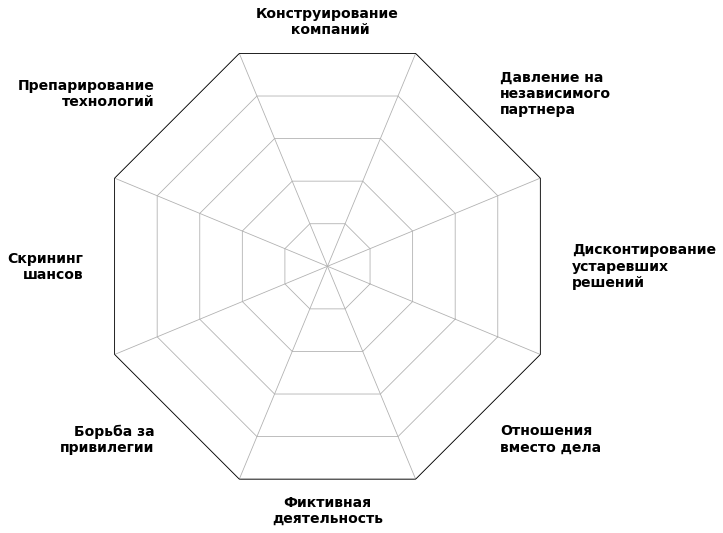

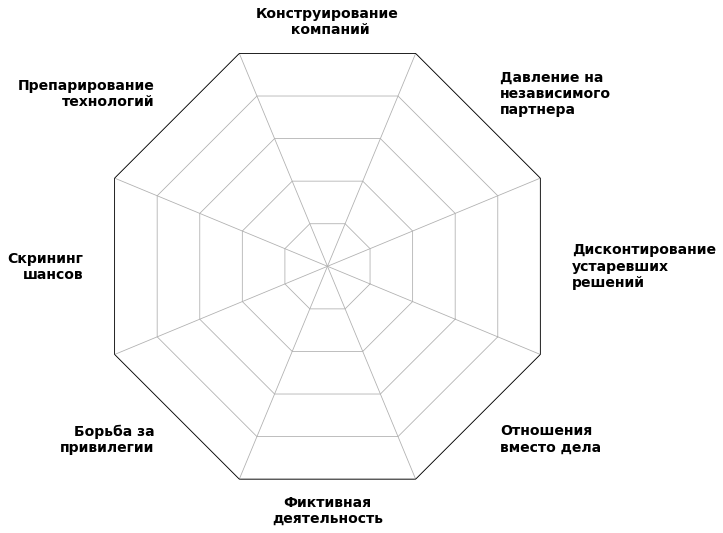

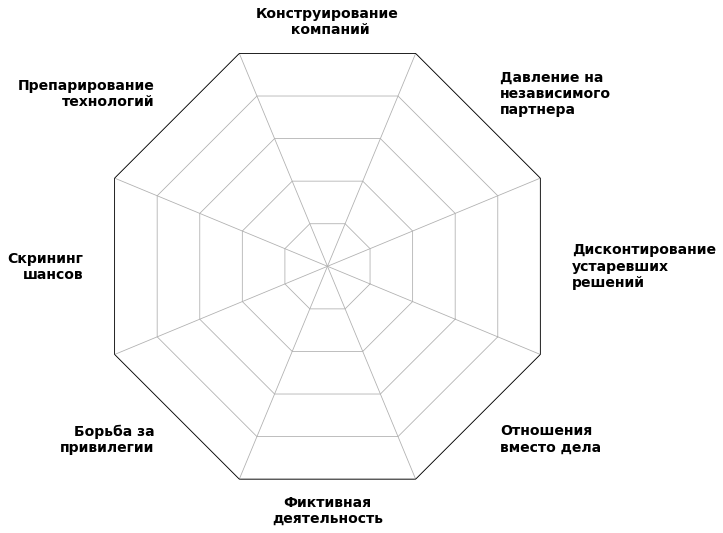

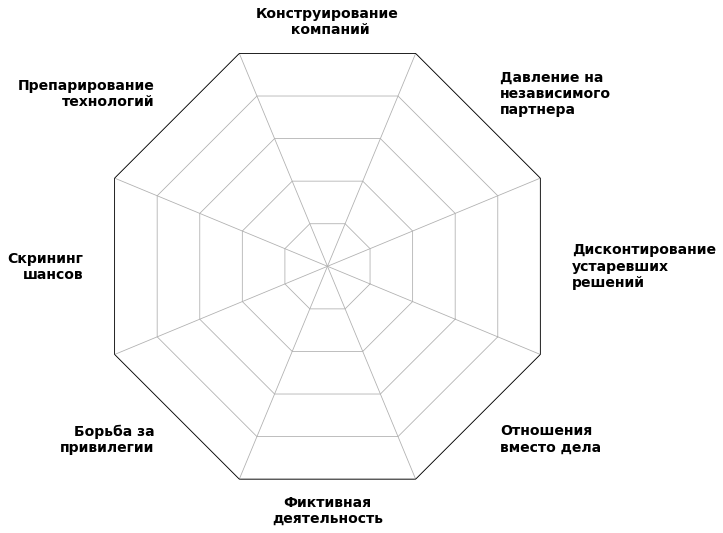

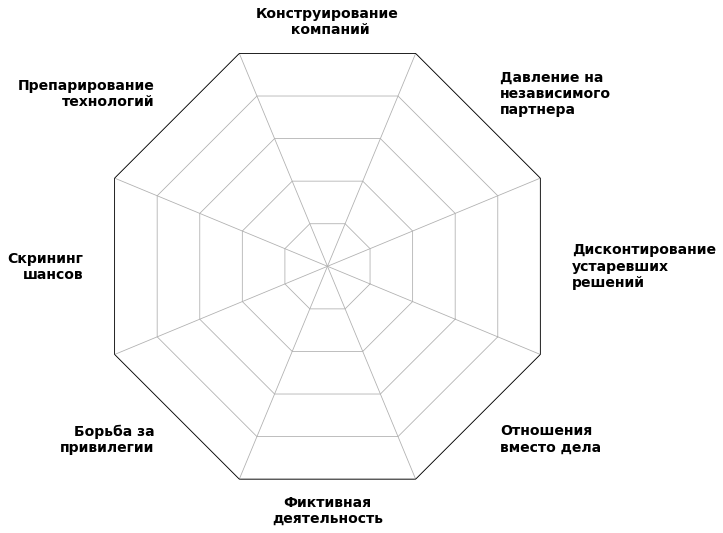

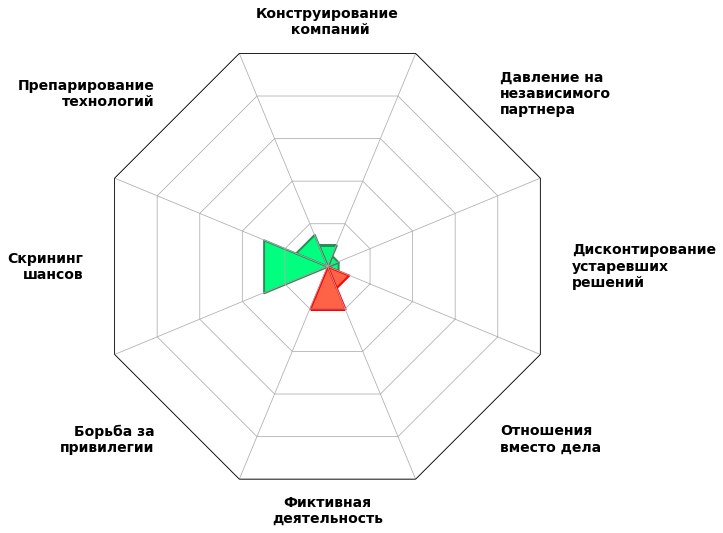

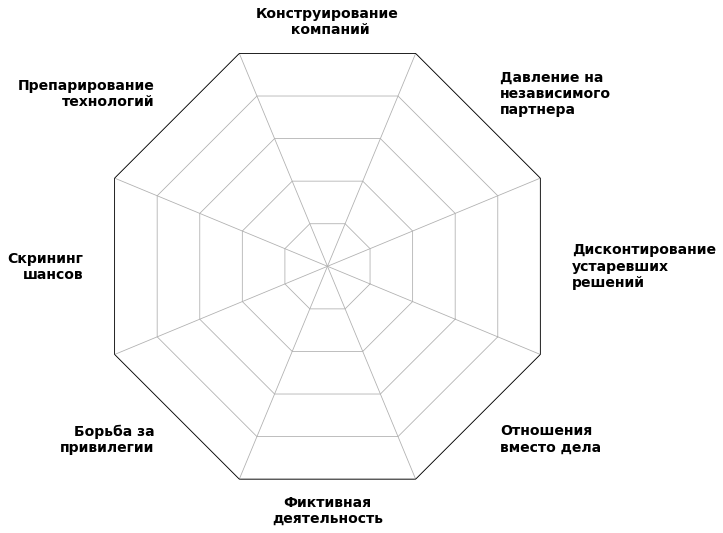

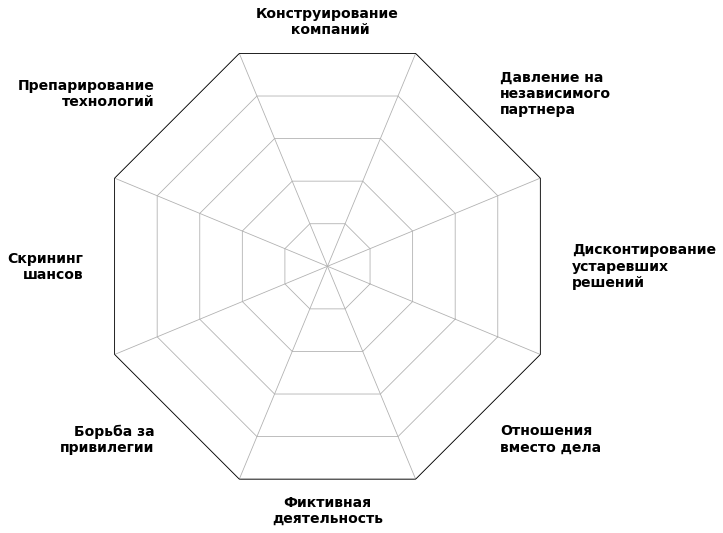

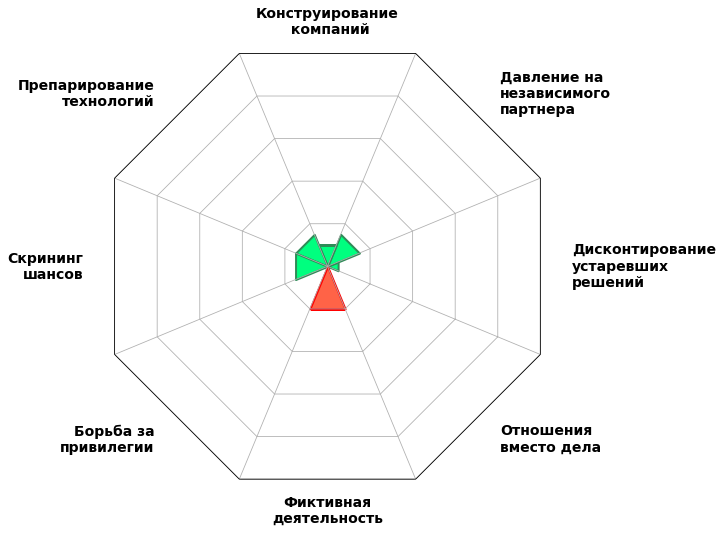

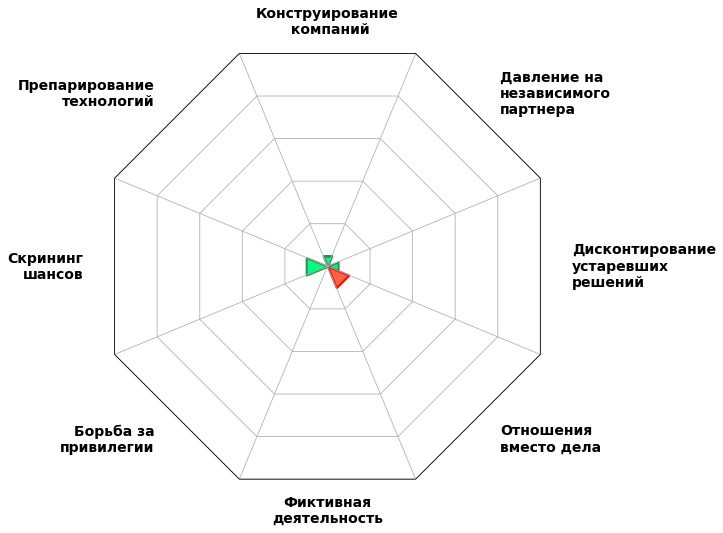

In [26]:
middle_time = time.time()

matplotlib.use('Agg')
keys = re.findall('{{(.+)}}', docx2txt.process(template))
keys.append('q1videoaudiourls')
result = []
items = []
k = 0

doc = DocxTemplate('Шаблончик.docx')
for email in tqdm(emails[:10]):
    count = 0
    context = {}
    for df in dfs:
        mail = email_col(df)
        df[mail] = df[mail].str.lower().str.replace(' ', '')
        for key in set(df.columns.to_list()).intersection(keys):
            try:
                context[key] = max(df[df[mail] == email][key], key=len)
                if key in ['score_test', 'time']:
                    context[key] = df[df[mail] == email].groupby([mail])[key].apply('  \n  '.join)[0]
                elif key == 'q1videoaudiourls':
                    count += 1
                    context['q' + str(count)] = max(df[df[mail] == email][key], key=len)
                elif key == 'question':
                    context[key] = df[df[mail] == email].groupby([mail])[key].apply('    \n    '.join)[0]
            except:
                pass
    try:
        last, name, patronymic = context['name'].split()
    except:
        pass
    context['name'] = max(df0[df0['ma_email'] == email]['name'], key=len)
    context['name'] = max(df0[df0['ma_email'] == email]['name_2'], key=len) + ' ' + context['name'] + ' ' + max(df0[df0['ma_email'] == email]['name_3'], key=len)
    context['email'] = email
    context['city'] = re.findall('ship-(.+)/test', max(df0[df0['ma_email'] == email]['referer'], key=len))[0]
    context['novel_score'], context['novel_translated'], context['novel_last'], context['novel_branch'], novel_numbers = novella_insert(email, data, rules)
    cases_pizza_numbers = score_cases_pizza(context)
    
    k += 1
    if novel_numbers != '-':
        context['novel_pizza'] = web(doc, novel_numbers+cases_pizza_numbers, k)
    else:
        context['novel_pizza'] = web(doc, cases_pizza_numbers, k)
        
    context['score'], context['cases_score'] = primary_point(context)
    context.update({key: 'пропуск' for key in keys if key not in context or context[key] == ''})
    context = context_check(context)
    items.append(context)
    
doc.render({'items':items})
doc.save('Анкеты 2.2 тест.docx')

for file_name in os.listdir():
    if file_name.startswith('web'):
        print(file_name)
        os.remove(file_name)
        
send()
print("Заполнение анкет: %s секунд" % round(time.time() - middle_time))

### Пользовательский интерфейс (Запуск Анкеты)

import PySimpleGUI as sg
import pandas as pd

layout = [
    [sg.Text('Таблица 1'), sg.InputText('Вопрос от Ивана Федосеева'), sg.FileBrowse('Указать путь')],
    [sg.Text('Таблица 2'), sg.InputText('Вопрос от Ольги Орловой'), sg.FileBrowse('Указать путь')],
    [sg.Text('Таблица 3'), sg.InputText('Вопрос от Катерины Ходуновой'), sg.FileBrowse('Указать путь')],
    [sg.Text('Таблица 4'), sg.InputText('Вопрос от Олега Лысака'), sg.FileBrowse('Указать путь')],
    [sg.Text('Таблица 5'), sg.InputText('Вопрос от Ивана Бородина'), sg.FileBrowse('Указать путь')],
    [sg.Text('Таблица 6'), sg.InputText('Тестирование 21 вопрос'), sg.FileBrowse('Указать путь')],
    [sg.Output(size=(88, 18))],
    [sg.Submit('Запустить'), sg.Cancel('Выйти')]
]


email = 'bgdshv.a@gmail.com'
context = {}
window = sg.Window('Анкеты + Первичный Балл', layout)
while True:
    event, values = window.read()
    if event in (None, 'Exit', 'Выйти'):
        break
    if event == 'Запустить':
        count = 0
        tables_input = [values[num] for num in range(6)]
        print(tables_input)
        ank()
window.close()